# Introduction

Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)

In [33]:
!pip install textstat

In [34]:
!pip install featdist

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
import datetime as dt
import math

from featdist import numerical_ttt_dist
from featdist import categorical_ttt_dist
import textstat

np.random.seed(0)
warnings.simplefilter("ignore")

In [36]:
train = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")
turns = pd.read_csv("../turns.csv")
games = pd.read_csv("../games.csv")
sub = pd.read_csv("../sample_submission.csv")

display(train.head())
display(test.head())
display(turns.head())
display(games.head())
display(sub.head())

,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811
3,3,BetterBot,318,2071
4,4,Inandoutworker,119,1473


,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN
4,11,STEEBot,334,1829.0


,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play


,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722


,game_id,rating
0,2,1790.322674
1,7,1790.322674
2,11,1790.322674
3,14,1790.322674
4,27,1790.322674


In [37]:
print("train shape:", train.shape)
print("test shape:", test.shape)
print("turns shape:", turns.shape)
print("games shape:", games.shape)
print("sub shape:", sub.shape)

train shape: (100820, 4)
test shape: (44726, 4)
turns shape: (2005498, 9)
games shape: (72773, 12)
sub shape: (22363, 2)


In [38]:
print("train nan value sum:", train.isna().sum().sum())
print("test nan value sum:", test.isna().sum().sum())
print("turns nan value sum:", turns.isna().sum().sum())
print("games nan value sum:", games.isna().sum().sum())

train nan value sum: 0
test nan value sum: 22363
turns nan value sum: 202478
games nan value sum: 0


In [39]:
turns.isna().sum()

game_id             0
turn_number         0
nickname            0
rack            69390
location       132239
move              454
points              0
score               0
turn_type         395
dtype: int64

In [40]:
print("train dublicated value sum:", train.duplicated().sum().sum())
print("test dublicated value sum:", test.duplicated().sum().sum())
print("turns dublicated value sum:", turns.duplicated().sum().sum())
print("games dublicated value sum:", games.duplicated().sum().sum())

train dublicated value sum: 0
test dublicated value sum: 0
turns dublicated value sum: 0
games dublicated value sum: 0


# Exploratory Data Analysis

## Feature Engineering

In [41]:
def fe_turns(df):
    df["rack_len"] = df["rack"].str.len()
    df["move_len"] = df["move"].str.len()
    df["move"].fillna("None",inplace=True)
    df["difficult_word"] = df["move"].apply(textstat.difficult_words)
    
    # FE ref: https://www.kaggle.com/code/ijcrook/full-walkthrough-eda-fe-model-tuning
    df["rack_len_less_than_7"] = df["rack_len"].apply(lambda x : x <7)
    rare_letters = ["Z", "Q", "J", "X", "K", "V", "Y", "W", "G"]
    df["difficult_letters"] = df["move"].apply(lambda x: len([letter for letter in x if letter in rare_letters]))
    df["points_per_letter"] = df["points"]/df["move_len"]
    df["direction_of_play"] = df["location"].apply(lambda x: 1 if str(x)[0].isdigit() else 0)
    df["curr_board_pieces_used"] = df["move"].apply(lambda x: str(x).count(".") + sum(int(c.islower()) for c in str(x)))
    #
    
    df["turn_type"].fillna("None",inplace=True)
    turn_type_unique = df["turn_type"].unique()
    df = pd.get_dummies(df, columns=["turn_type"])
    dummy_features = [f"turn_type_{value}" for value in turn_type_unique]
    
    char_map = {
        'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8,
        'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15,
    }
    df["loc_nan"] = df["location"].isna()
    df['y'] = df["location"].str.extract('(\d+)')[0].values
    df['y'].fillna("0",inplace=True)
    df["y"] = df["y"].astype(int)
    
    df["x"] = df["location"].str.extract('([A-Z])')[0].values
    df["x"].replace(char_map, inplace=True)
    df['y'].fillna("0",inplace=True)
    df["y"] = df["y"].astype(int)
    
    return df, dummy_features

In [42]:
turns_fe, dummy_features = fe_turns(turns.copy())
turns_fe["game_count"] = turns_fe["game_id"]

agg_features = ["points", "score", "rack_len", "move_len", "difficult_word", "loc_nan", "x", "y", 
                 "rack_len_less_than_7", "difficult_letters", "points_per_letter", "direction_of_play", 
                 "curr_board_pieces_used"] + dummy_features
agg_func = {feature:['mean', 'sum', 'max'] for feature in agg_features}
agg_func["game_count"] = "count"
    
turns_group = turns_fe.groupby(["game_id", "nickname"], as_index=False).agg(agg_func)
turns_group.columns = ['_'.join(col) for col in turns_group.columns]
turns_group_bot = turns_group[turns_group["nickname_"].isin(["BetterBot", "STEEBot", "HastyBot"])]
turns_group_bot.columns = [col+'_bot' for col in turns_group_bot.columns]
turns_group_player = turns_group[~turns_group["nickname_"].isin(["BetterBot", "STEEBot", "HastyBot"])]
print("turns_group_bot.shape:",turns_group_bot.shape)
print("turns_group_player.shape:",turns_group_player.shape)
turns_group_all = pd.concat([turns_group_player.reset_index(), turns_group_bot.reset_index()], axis=1, ignore_index=False)
turns_group_all.drop("index", axis=1, inplace=True)
print("turns_group_all.shape:",turns_group_all.shape)
turns_group_all.head()

turns_group_bot.shape: (72773, 66)
turns_group_player.shape: (72773, 66)
turns_group_all.shape: (72773, 132)


,game_id_,nickname_,points_mean,points_sum,points_max,score_mean,score_sum,score_max,rack_len_mean,rack_len_sum,...,turn_type_Challenge_mean_bot,turn_type_Challenge_sum_bot,turn_type_Challenge_max_bot,turn_type_Six-Zero Rule_mean_bot,turn_type_Six-Zero Rule_sum_bot,turn_type_Six-Zero Rule_max_bot,turn_type_None_mean_bot,turn_type_None_sum_bot,turn_type_None_max_bot,game_count_count_bot
0,1,stevy,30.642857,429,98,256.500000,3591,429,6.538462,85.0,...,0.0,0,False,0.0,0,False,0.0,0,False,13
1,2,Super,34.857143,488,94,282.285714,3952,488,7.000000,91.0,...,0.0,0,False,0.0,0,False,0.0,0,False,12
2,3,davidavid,31.428571,440,103,231.714286,3244,440,6.692308,87.0,...,0.0,0,False,0.0,0,False,0.0,0,False,13
3,4,Inandoutworker,8.500000,119,26,85.000000,1190,119,7.000000,98.0,...,0.0,0,False,0.0,0,False,0.0,0,False,15
4,5,stevy,20.312500,325,51,203.312500,3253,325,6.466667,97.0,...,0.0,0,False,0.0,0,False,0.0,0,False,15


In [43]:
def feature_agg(df, turns_group, games):
    df_bot = df[df["nickname"].isin(["BetterBot", "STEEBot", "HastyBot"])]
    
    df["nickname_count"] = df["nickname"].replace(df["nickname"].value_counts())
    df = df.merge(turns_group, left_on=["game_id", "nickname"], right_on=["game_id_", "nickname_"], how='inner', suffixes=["", "_agg"])
    df = df.merge(df_bot, left_on=["game_id"], right_on=["game_id"], how='left', suffixes=["", "_bot"])
    df.drop(["game_id_", "nickname_", "nickname_bot", "game_id__bot"], axis=1,inplace=True)
    
    games["created_at"] = pd.to_datetime(games["created_at"])
    df = df.merge(games, left_on="game_id", right_on='game_id', how='left')
    df["first"] = df["first"] == df["nickname"]
    df["first"] = df["first"].astype(int)
    df["winner"] = df["winner"] == df["first"]
    df["winner"] = df["winner"].astype(int)
    return df

In [44]:
train_fe = feature_agg(train, turns_group_all, games)
test_fe = feature_agg(test, turns_group_all, games)
train_fe.head()

,game_id,nickname,score,rating,nickname_count,points_mean,points_sum,points_max,score_mean,score_sum,...,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,stevy,429,1500,410,30.642857,429,98,256.500000,3591,...,regular,STANDARD,0,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,3,davidavid,440,1811,254,31.428571,440,103,231.714286,3244,...,regular,STANDARD,0,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
2,4,Inandoutworker,119,1473,205,8.500000,119,26,85.000000,1190,...,regular,RESIGNED,1,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
3,5,stevy,325,1500,410,20.312500,325,51,203.312500,3253,...,regular,STANDARD,1,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722
4,6,HivinD,378,2029,592,31.500000,378,74,184.333333,2212,...,regular,STANDARD,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,426.950541


In [45]:
bad_features = []
for f in train_fe.columns:
    if train_fe[f].nunique() < 2:
        bad_features.append(f)

print("bad_features len:",len(bad_features))
train_fe.drop(bad_features, axis=1, inplace=True)
test_fe.drop(bad_features, axis=1, inplace=True)

bad_features len: 9


In [46]:
train_fe.fillna(0, inplace=True)
test_fe.fillna(0, inplace=True)

In [47]:
train_fe.to_feather("train_fe.feather")
test_fe.to_feather("test_fe.feather")

## Distributions

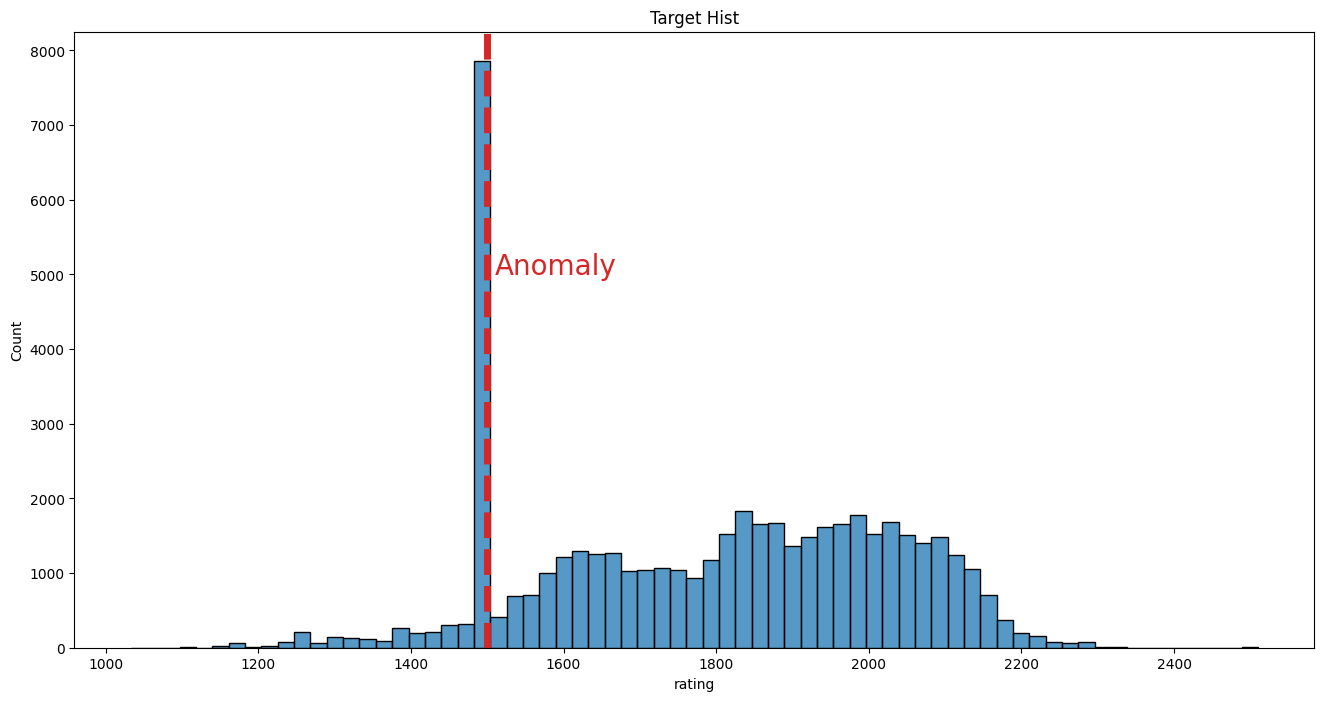

In [48]:
fig, ax = plt.subplots(figsize=(16,8))
sns.histplot(data=train_fe, x="rating", ax=ax);
ax.axvline(1500, color="tab:red", linewidth=5, linestyle="--");
ax.text(1510, 5000, "Anomaly", fontsize=20,color="tab:red");
ax.set_title("Target Hist");

In [49]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
num_features = train_fe.select_dtypes(include=numerics).columns.tolist()
num_features.remove("rating")
bool_features = train_fe.select_dtypes(include=["bool"]).columns.tolist()
cat_features = train_fe.select_dtypes(include=["object"]).columns.tolist()

print("num_features len:",len(num_features))
print("bool_features len:",len(bool_features))
print("cat_features len:",len(cat_features))

num_features len: 113
bool_features len: 17
cat_features len: 6


In [50]:
NBINS = 11
num_features_bins = []
less_bins = []
for f in num_features:
    if train_fe[f].nunique() >= NBINS:
        num_features_bins.append(f)
    else:
        less_bins.append(f)
print("num_features_bins len:",len(num_features_bins))
print("less_bins:", less_bins)

num_features_bins len: 90
less_bins: ['difficult_word_sum', 'difficult_word_max', 'difficult_letters_max', 'direction_of_play_max', 'turn_type_End_sum', 'turn_type_Timeout_sum', 'turn_type_Six-Zero Rule_sum', 'turn_type_None_sum', 'difficult_word_max_bot', 'x_max_bot', 'y_max_bot', 'difficult_letters_max_bot', 'direction_of_play_max_bot', 'turn_type_End_sum_bot', 'turn_type_Exchange_sum_bot', 'turn_type_Pass_sum_bot', 'turn_type_Six-Zero Rule_sum_bot', 'turn_type_None_mean_bot', 'turn_type_None_sum_bot', 'first', 'winner', 'increment_seconds', 'max_overtime_minutes']


* nickname_count is not a well distributed feature

# Validation

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.base import clone

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [52]:
train_fe = pd.read_feather("./train_fe.feather")
test_fe = pd.read_feather("./test_fe.feather")

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
num_features = train_fe.select_dtypes(include=numerics).columns.tolist()
num_features.remove("game_id")
num_features.remove("rating")

# Less correlated dist between the train and the test
#num_features.remove("initial_time_seconds")
#num_features.remove("rating_bot")
#num_features.remove("nickname_count")

bool_features = train_fe.select_dtypes(include=["bool"]).columns.tolist()
cat_features = train_fe.select_dtypes(include=["object"]).columns.tolist()
cat_features.remove("nickname")
cat_features.remove("nickname__bot")
#features = num_features + cat_features + bool_features
features = num_features + cat_features

print("num_features len:",len(num_features))
print("bool_features len:",len(bool_features))
print("cat_features len:",len(cat_features))

X = train_fe[features]
y = train_fe[["rating"]]
X_test = test_fe[features]

for feature in cat_features:
    X[feature] = X[feature].replace(X[feature].value_counts(normalize=True))
    X_test[feature] = X_test[feature].replace(X_test[feature].value_counts(normalize=True))
    
print("X.shape:", X.shape)
print("y.shape:", y.shape)
print("X_test.shape:", X_test.shape)

num_features len: 112
bool_features len: 17
cat_features len: 4
X.shape: (50410, 116)
y.shape: (50410, 1)
X_test.shape: (22363, 116)


In [53]:
def get_scores(model_dict, X, y, X_test, nfolds=5):
    df_score_details = {
        'model':[],
        'r2':[],
        'rmse':[],
    }
    fig, axes = plt.subplots(len(model_dict), figsize=(16, 4*len(model_dict)))
    for fig_index, model_key in enumerate(model_dict.keys()):
        kf = KFold(n_splits=nfolds)
        np_test = np.zeros((len(X_test)))
        val_r2_scores = []
        val_rmse_scores = []
        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            X_train, X_val = X.loc[train_index,:], X.loc[val_index,:]
            y_train, y_val = y.loc[train_index,:], y.loc[val_index,:]
            
            model = model_dict[model_key]
            model.fit(X_train, y_train)
            
            val_preds = model.predict(X_val).reshape(-1)
            test_preds = model.predict(X_test).reshape(-1)
            
            val_r2_scores.append(r2_score(y_val, val_preds))
            val_rmse_scores.append(mean_squared_error(y_val, val_preds, squared=False))
            
            np_test += test_preds / nfolds
        df_score_details["model"].append(model_key)
        df_score_details["r2"].append(np.mean(val_r2_scores))
        df_score_details["rmse"].append(np.mean(val_rmse_scores))
        
        sub = pd.read_csv("../input/scrabble-player-rating/sample_submission.csv")
        sub.loc[sub["rating"].isna(), "rating"] = np_test
        sub.to_csv(f"{model_key}_baseline_sub.csv",index=False)
        
        axes[fig_index].hist(y, color='tab:blue', label='train', bins=50, density=True, alpha=0.5)
        axes[fig_index].hist(sub["rating"], color='tab:red', label='test', bins=50, density=True, alpha=0.5)
        axes[fig_index].set_title(model_key)
        axes[fig_index].legend()
    df_score = pd.DataFrame(df_score_details)
    gc.collect()
    plt.show()
    return df_score

In [54]:
model_dict = {
    'lr':LinearRegression(),
    'ridge':Ridge(),
    'dt':DecisionTreeRegressor(),
    'rf':RandomForestRegressor(),
    'lgb':lgb.LGBMRegressor(),
}
#df_score = get_scores(model_dict, X, y, X_test, nfolds=5)

In [55]:
df_score_details = {'model': {0: 'lr', 1: 'ridge', 2: 'dt', 3: 'rf', 4: 'lgb'},
 'r2': {0: 0.6130722539459688,
  1: 0.6130003820326145,
  2: 0.5079049576294109,
  3: 0.7554189363524964,
  4: 0.7482953578278093},
 'rmse': {0: 142.86110682061616,
  1: 142.87432546020736,
  2: 161.09238311693016,
  3: 113.56680458868478,
  4: 115.20888248520865},
  'lb':{0:160.95957,
  1: 161.01134,
  2: 172.17746,
  3: 157.34657,
  4: 156.36289}}
df_score = pd.DataFrame(df_score_details)
df_score.sort_values("lb",inplace=True,ascending=True)
df_score

,model,r2,rmse,lb
4,lgb,0.748295,115.208882,156.36289
3,rf,0.755419,113.566805,157.34657
0,lr,0.613072,142.861107,160.95957
1,ridge,0.613000,142.874325,161.01134
2,dt,0.507905,161.092383,172.17746


# Modeling

## Hyperparameter Tuning

In [56]:
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.01,
        "max_depth":6,
        'random_state': 42,
        "n_jobs":-1,
        "seed":123,
        "verbose":-1,
        "num_leaves":trial.suggest_int('num_leaves', 10, 200, step=10),
        "min_data_in_leaf":trial.suggest_int('min_data_in_leaf', 10, 100, step=10),
        'lambda_l1': trial.suggest_float('alpha', 0.0001, 10.0),
        'lambda_l2': trial.suggest_float('lambda', 0.0001, 10.0),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0, step=0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1.0, step=0.1),
    }
    
    skf = KFold(n_splits=5, random_state=0, shuffle=True)
    trainlist, validlist = [], []
    for train_index, val_index in skf.split(X, y):
        trainlist.append(train_index)
        validlist.append(val_index)
    folds = zip(trainlist, validlist)
    
    dataset = lgb.Dataset(X, y)
    res = lgb.cv(
        params, dataset, num_boost_round=1000, verbose_eval=0,
        early_stopping_rounds=10,
        folds=folds,
        stratified=False,
    )
    
    return res["rmse-mean"][-1] + res["rmse-stdv"][-1]

In [57]:
'''
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=18000)
print('Number of finished trials: ', len(study.trials))
print('Best trial: ', study.best_trial.params)
print('Best value: ', study.best_value)
'''

"\nstudy = optuna.create_study(direction='minimize')\nstudy.optimize(objective, n_trials=100, timeout=18000)\nprint('Number of finished trials: ', len(study.trials))\nprint('Best trial: ', study.best_trial.params)\nprint('Best value: ', study.best_value)\n"

In [62]:
def get_scores_lgbm(params, X, y, X_test, nfolds=5):
    df_score_details = {
        'model':[],
        'r2':[],
        'rmse':[],
    }
    fig, ax = plt.subplots(figsize=(16, 4))
    for fig_index in range(1):
        model_key = "lgbm"
        kf = KFold(n_splits=nfolds)
        np_test = np.zeros((len(X_test)))
        val_r2_scores = []
        val_rmse_scores = []
        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            X_train, X_val = X.loc[train_index,:], X.loc[val_index,:]
            y_train, y_val = y.loc[train_index,:], y.loc[val_index,:]
            
            dtrain = lgb.Dataset(X_train, y_train)
            dval = lgb.Dataset(X_val, y_val)
            
            evals_result = {}
            model = lgb.train(params=params, train_set=dtrain, valid_sets=[dval], num_boost_round=10000, 
            )
            
            val_preds = model.predict(X_val).reshape(-1)
            test_preds = model.predict(X_test).reshape(-1)
            
            val_r2_scores.append(r2_score(y_val, val_preds))
            val_rmse_scores.append(mean_squared_error(y_val, val_preds, squared=False))
            
            np_test += test_preds / nfolds
        df_score_details["model"].append(model_key)
        df_score_details["r2"].append(np.mean(val_r2_scores))
        df_score_details["rmse"].append(np.mean(val_rmse_scores))
        
        sub = pd.read_csv("../sample_submission.csv")
        sub["rating"] = np_test
        sub.to_csv(f"{model_key}_baseline_sub.csv",index=False)
        
        ax.hist(y, color='tab:blue', label='train', bins=50, density=True, alpha=0.5)
        ax.hist(sub["rating"], color='tab:red', label='test', bins=50, density=True, alpha=0.5)
        ax.set_title(model_key)
        ax.legend()
    df_score = pd.DataFrame(df_score_details)
    gc.collect()
    plt.show()
    return df_score

FileNotFoundError: [Errno 2] No such file or directory: '../input/scrabble-player-rating/sample_submission.csv'

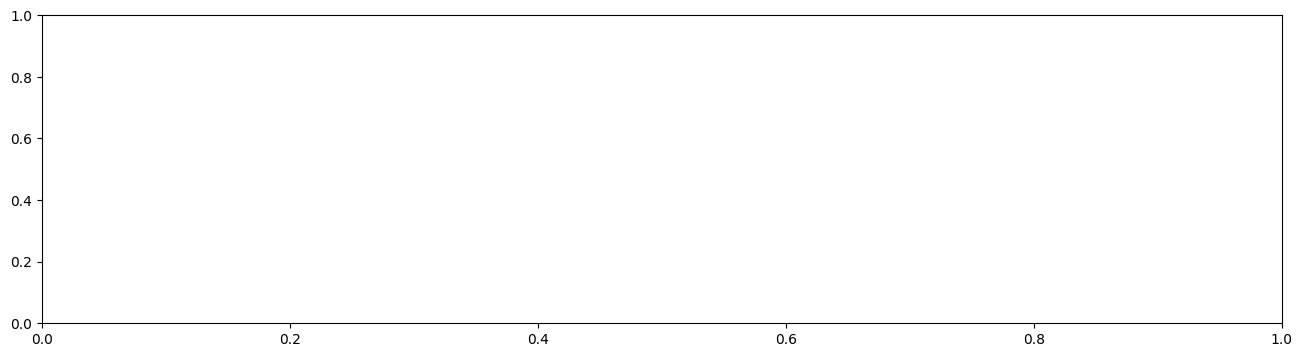

In [64]:
params_lgbm = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.01,
        "max_depth":6,
        'random_state': 42,
        "n_jobs":-1,
        "seed":123,
        "verbose":-1,
        'num_leaves': 170, 
        'min_data_in_leaf': 10, 
        'alpha': 6.213527693669625, 
        'lambda': 0.1701794289469321, 
        'subsample': 0.7, 
        'feature_fraction': 0.8,
    }

df_score = get_scores_lgbm(params_lgbm, X, y, X_test, nfolds=4)

In [ ]:
df_score

,model,r2,rmse
0,lgbm,0.905608,70.547761
